In [1]:
import os
import h5py
import numpy as np

import sys
sys.path.append("../..") 
from cryoem.plots import plot_angles_count, plot_euclidean_space, save_space_plot, plot_SO3_space
from IPython.display import Image
from cryoem.angle_recovery import train_angle_recovery

import tensorflow as tf
from cryoem.quaternions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ,plot_dP_dQ_density,plot_only_selected_in_euclidean_space, plot_rays
from cryoem.angle_recovery import geodesic_distance, update_angles, distance_difference, find_best_rotation

In [2]:
PROTEIN="5a1a"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

In [3]:
# location of *.h5 files
data_dir = f"{ROOT_DIR}/data"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (275, 275) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [4]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

In [88]:
projections = data['Projections']

In [91]:
projections[0].shape

(275, 275)

In [5]:
#ap_mod = np.load("predicted_angles_mod.npy")
ap = np.load("data/predicted_angles.npy")

In [6]:
plot_only_selected_in_euclidean_space(ap, angles_true, range(100))

In [92]:
def rotate_image(angles, vector):
    # create rotation matrix
    c1 = np.cos(angles[:,0]).reshape(-1,1,1)
    c2 = np.cos(angles[:,1]).reshape(-1,1,1)
    c3 = np.cos(angles[:,2]).reshape(-1,1,1)

    s1 = np.sin(angles[:,0]).reshape(-1,1,1)
    s2 = np.sin(angles[:,1]).reshape(-1,1,1)
    s3 = np.sin(angles[:,2]).reshape(-1,1,1)

    R = np.concatenate([np.concatenate([c1*c2*c3-s1*s3, c1*s3+c2*c3*s1 , -c3*s2],axis=2),\
                    np.concatenate([-c3*s1-c1*c2*s3,    c1*c3-c2*s1*s3 ,   s2*s3],axis=2),\
                    np.concatenate( [c1*s2,             s1*s2          ,   c2],axis=2)],axis=1)

    # rotate previous values
    for i, v in enumerate(vector):
        vector[i] = np.matmul(R,vector[i])

    return vector

In [133]:
import matplotlib.pyplot as plt
import ipyvolume as ipv
from cryoem.projections import RotationMatrix
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np
from matplotlib._png import read_png
from matplotlib.cbook import get_sample_data

def getXYZ(p1, angles, projection):
    #arr1 = read_png("figures/lena.png")
    #print(arr1.shape)
    img_size_scale = 0.05
    #print(arr1.shape)
    #arr = arr1[:,:,1]
    projection = projection/np.max(projection)
    img = np.zeros((projection.shape[0], projection.shape[1], 3))
    img[:,:,0] = projection
    img[:,:,1] = projection
    img[:,:,2] = projection

    x = np.linspace(-img_size_scale/2, img_size_scale/2, img.shape[0])
    y = np.linspace(-img_size_scale/2, img_size_scale/2, img.shape[1])
    X, Y = np.meshgrid(x, y)
    x_shape = X.shape
    y_shape = Y.shape
    X = X.flatten() 
    Y = Y.flatten()
    
    Z = np.zeros(X.shape)
    vector = np.column_stack((X, Y, Z))
    rotated_vector = rotate_image(angles, vector)
    
    X = rotated_vector[:,0].reshape(x_shape)+p1[0]
    Y = rotated_vector[:,1].reshape(y_shape)+p1[1]
    Z = rotated_vector[:,2].reshape(x_shape)+p1[2]
    return X, Y, Z, img
    
def plot_images(angles, projections, indices=range(3)):
    arr = RotationMatrix(angles)

    ipv.clear()
    ipv.figure(width=500, height=500)
    indices=indices if indices else range(len(arr))
    scale = 0.2

    for i in indices:
#         ipv.scatter(arr[i:i+1,0], arr[i:i+1,1], arr[i:i+1,2], marker="sphere", color="blue", size=1)
#         ipv.scatter(arr[i,0]+arr[i:i+1,6]*scale, arr[i,1]+arr[i:i+1,7]*scale, arr[i,2]+arr[i:i+1,8]*scale, marker="sphere", color="red", size=1)
#         ipv.scatter(arr[i,0]+arr[i:i+1,9]*scale, arr[i,1]+arr[i:i+1,10]*scale, arr[i,2]+arr[i:i+1,11]*scale, marker="sphere", color="green", size=1)


#         connection0 = [arr[i,0], arr[i,0]+arr[i,6]*scale]
#         connection1 = [arr[i,1], arr[i,1]+arr[i,7]*scale]
#         connection2 = [arr[i,2], arr[i,2]+arr[i,8]*scale]
#         ipv.plot(connection0, connection1, connection2,color="red", lynestyle="--")
#         connection0 = [arr[i,0], arr[i,0]+arr[i,9]*scale]
#         connection1 = [arr[i,1], arr[i,1]+arr[i,10]*scale]
#         connection2 = [arr[i,2], arr[i,2]+arr[i,11]*scale]
#         ipv.plot(connection0, connection1, connection2,color="green", lynestyle="--")

        n_corss= -np.cross(arr[i,6:9],arr[i,9:12])
        connection0 = [arr[i,0], arr[i,0]+n_corss[0]]
        connection1 = [arr[i,1], arr[i,1]+n_corss[1]]
        connection2 = [arr[i,2], arr[i,2]+n_corss[2]]
        ipv.plot(connection0, connection1, connection2,color="blue", lynestyle="--")
        ipv.xlim(-1,1);ipv.ylim(-1,1);ipv.zlim(-1,1)


        X, Y, Z, img = getXYZ(arr[i], np.array([angles[i]]), projections[i])

        ipv.plot_surface(X, Y, Z, color=img)

    
    ipv.show()


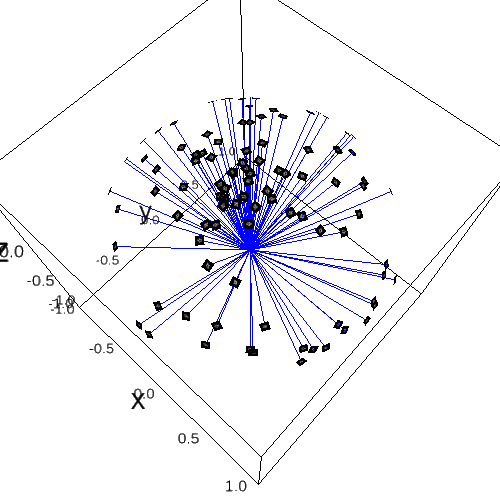

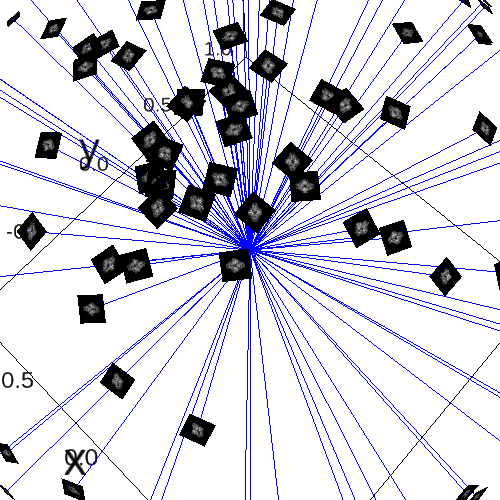

In [134]:
plot_images(ap, projections, indices=range(100))

In [136]:
filename = f"figures/{PROTEIN}_images"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()